# ETL Process

Import Libraries

> Comment each library for what is???

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Load dataset

In [19]:
s3_url_train = "https://gatitoenamoraobucket.s3.amazonaws.com/titanic/train.csv"
data_frame = pd.read_csv(s3_url_train)

Show features from dataset

In [8]:
print(data_frame.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [10]:
#Print the first 5 rows of the data set
data_frame.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature Engineering

See all caracteristics from the data

In [ ]:
#Pandas profiling on the data frame
from ydata_profiling import ProfileReport
profile = ProfileReport(data_frame, title="Pandas Profiling Report")
profile

Encode all the data

In [22]:
le = LabelEncoder()
data_frame['Sex'] = le.fit_transform(data_frame['Sex']) # male = 1, female = 0

Drop unecesary columns

> Add Justifying of each data, why do we keep certain columns and delete other ones

In [30]:
data_frame = data_frame.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'])

Encode necessary columns

In [31]:
le = LabelEncoder()
# Male = 1, female =0
data_frame['Sex'] = le.fit_transform(data_frame['Sex']) # male = 1, female = 0

Fill Missing values

In [32]:
#Fill missing embarged values with the most common value class which is S
data_frame['Embarked'] = data_frame['Embarked'].fillna('S')
data_frame['Embarked'] = le.fit_transform(data_frame['Embarked']) 

# Fill the age with median to keep the structure of the graph
data_frame['Age'] = data_frame['Age'].fillna(data_frame['Age'].median())  
data_frame['Fare'] = data_frame['Fare'].fillna(data_frame['Fare'].median())

Normalizing the caracteristics from the data frame

In [33]:
scaler = StandardScaler()
data_frame_scaled = scaler.fit_transform(data_frame)

**Correlation Matrix**

> Add Justification as why we see each data, also add a correlation matrix for all the possible data

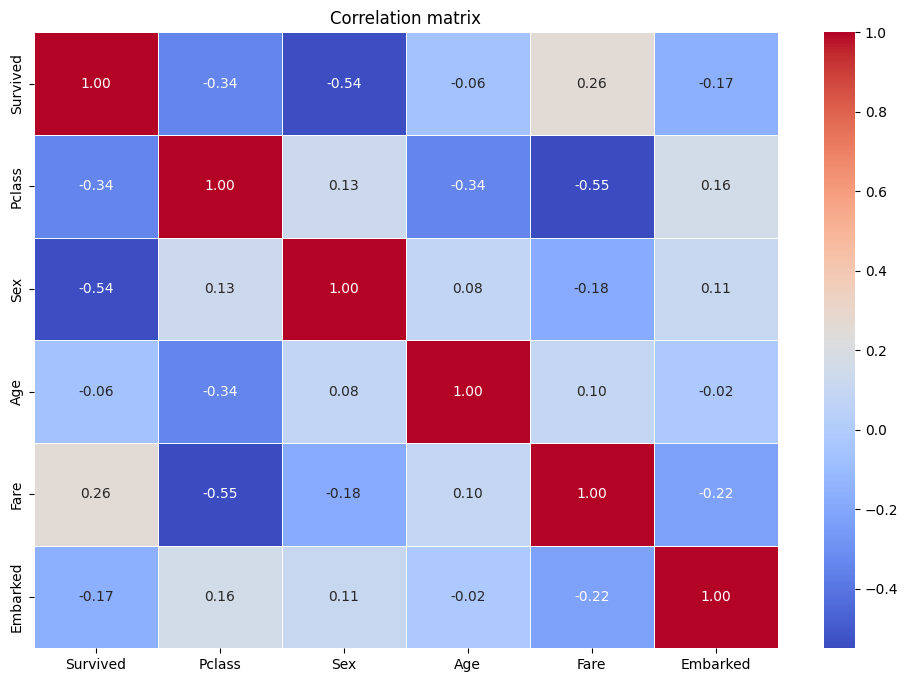

In [34]:
#Correlation matrix
correlation_matrix = data_frame.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation matrix')
plt.savefig('correlation_matrix.png')

Verify if all the null values are gone and check which columns left

In [36]:
data_frame.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
Fare        0
Embarked    0
dtype: int64

**Execute PCA**

> Add explanation of why we reduce the dimensionality first and then we did PCA. Good Justification

In [38]:
 #Execute PCA
pca = PCA(n_components=6)
principal_components = pca.fit_transform(data_frame_scaled)

df_pca = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(6)])

print(df_pca.head())
print("")
print("Explained variance ratio: ", pca.explained_variance_ratio_)
print("")
print("Total variance explained: ", sum(pca.explained_variance_ratio_))

        PC1       PC2       PC3       PC4       PC5       PC6
0  1.595214 -0.087184 -0.066255 -0.453619 -0.013851  0.069922
1 -2.989151 -0.016009 -0.756932  1.003215  0.082002 -0.454444
2 -0.275634 -1.771798  1.010748  0.574786 -0.101184  0.446078
3 -2.057747 -0.237568  1.409015  0.030681  0.225227 -0.525256
4  1.441764  0.543686  0.248214  0.152172 -0.192551  0.351002

Explained variance ratio:  [0.35520625 0.22407004 0.15560896 0.12807341 0.08174347 0.05529788]

Total variance explained:  1.0000000000000004


In [40]:
# Get the loadings for each principal component
loadings = pd.DataFrame(pca.components_, columns=data_frame.columns)

# Display the loadings
print("PCA Component Loadings:")
print(loadings)

# Optionally, show the absolute values of the loadings for easier interpretation
print("\nAbsolute Values of PCA Component Loadings:")
print(loadings.abs())

# If you want to see which variable contributes the most to each principal component
for i in range(len(loadings)):
    print(f"\nTop contributing feature(s) to PC{i+1}:")
    print(loadings.iloc[i].nlargest(6))  # Adjust the number of top features as needed


PCA Component Loadings:
   Survived    Pclass       Sex       Age      Fare  Embarked
0 -0.487437  0.515184  0.390336 -0.145650 -0.492851  0.283747
1 -0.393913 -0.378142  0.511444  0.628019  0.214147  0.000646
2  0.204564 -0.130738 -0.267944  0.317143 -0.147325  0.864282
3  0.127580  0.189462 -0.279262  0.615521 -0.567683 -0.410743
4  0.568335 -0.353719  0.571920 -0.171754 -0.441317 -0.022919
5  0.475511  0.643031  0.330437  0.274651  0.415342  0.057183

Absolute Values of PCA Component Loadings:
   Survived    Pclass       Sex       Age      Fare  Embarked
0  0.487437  0.515184  0.390336  0.145650  0.492851  0.283747
1  0.393913  0.378142  0.511444  0.628019  0.214147  0.000646
2  0.204564  0.130738  0.267944  0.317143  0.147325  0.864282
3  0.127580  0.189462  0.279262  0.615521  0.567683  0.410743
4  0.568335  0.353719  0.571920  0.171754  0.441317  0.022919
5  0.475511  0.643031  0.330437  0.274651  0.415342  0.057183

Top contributing feature(s) to PC1:
Pclass      0.515184
Sex   

Analize the data distribution of the principal components

> Add explanation of what is PC1, PC2, etc

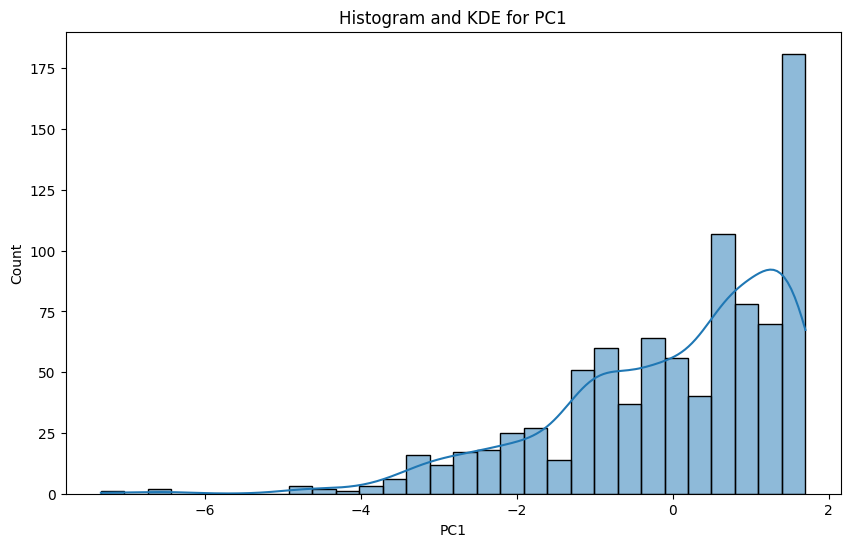

<Figure size 600x600 with 0 Axes>

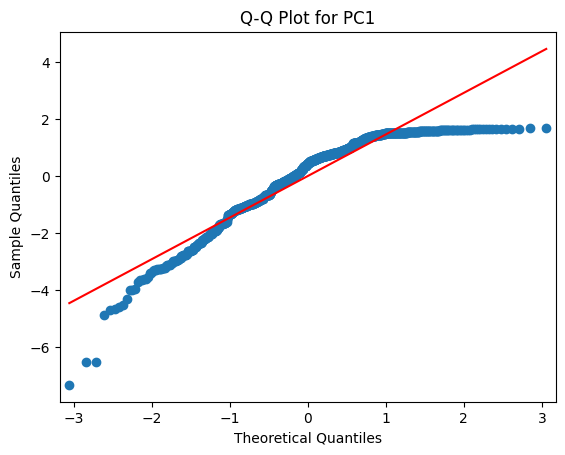

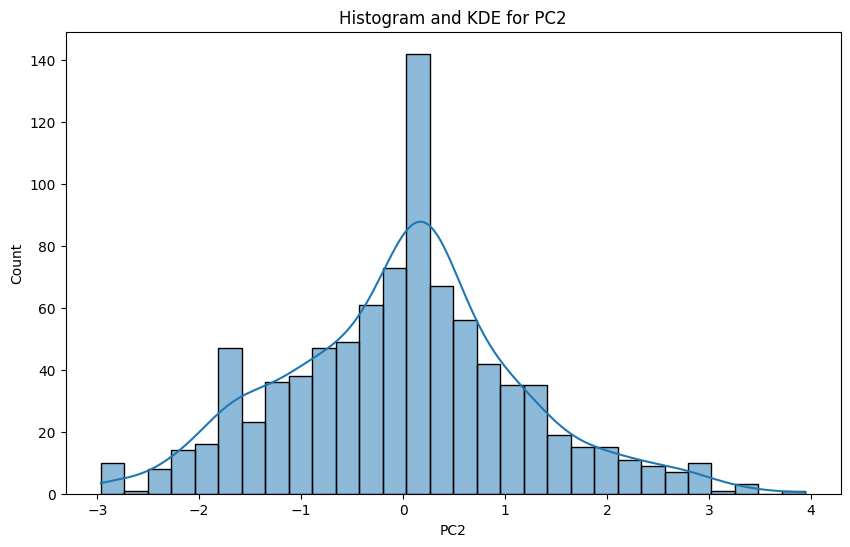

<Figure size 600x600 with 0 Axes>

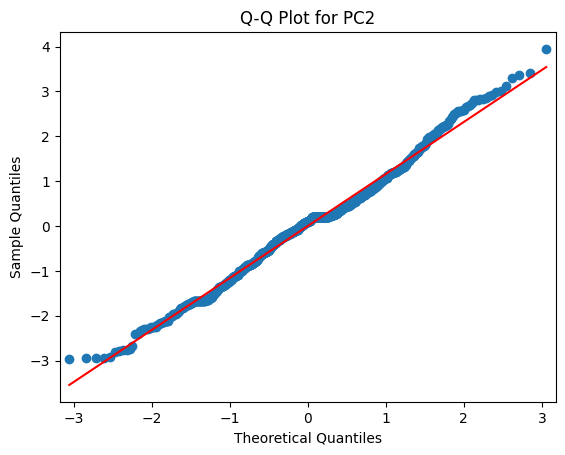

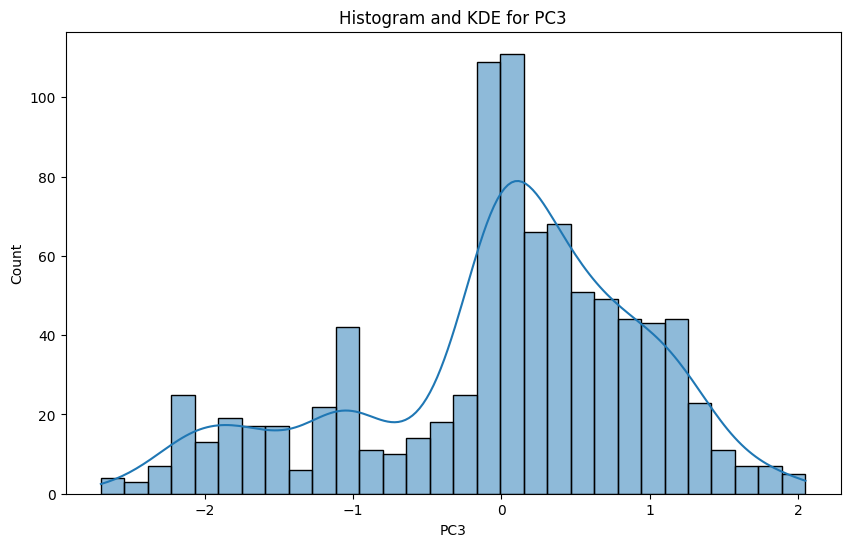

<Figure size 600x600 with 0 Axes>

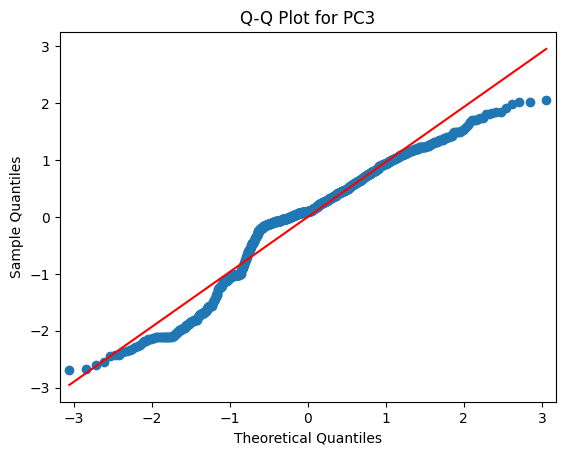

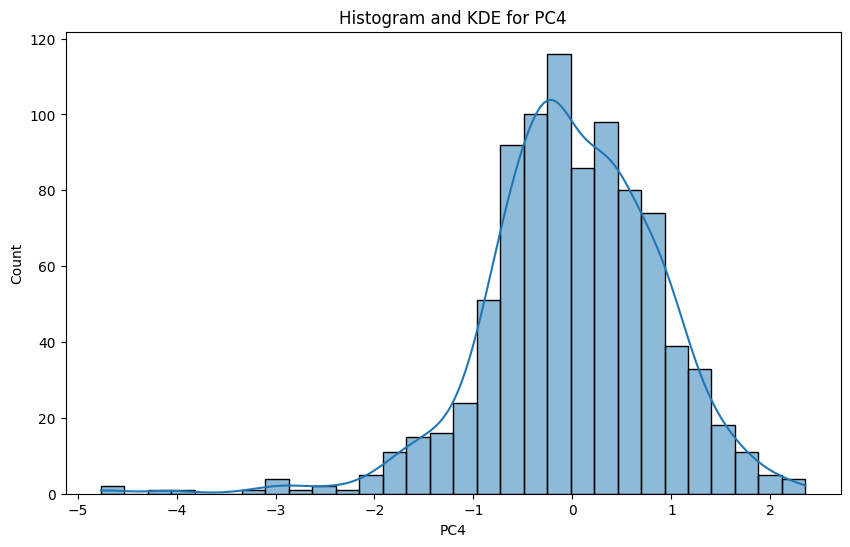

<Figure size 600x600 with 0 Axes>

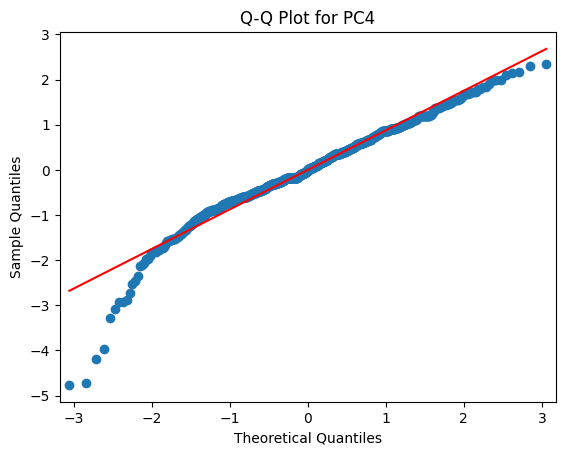

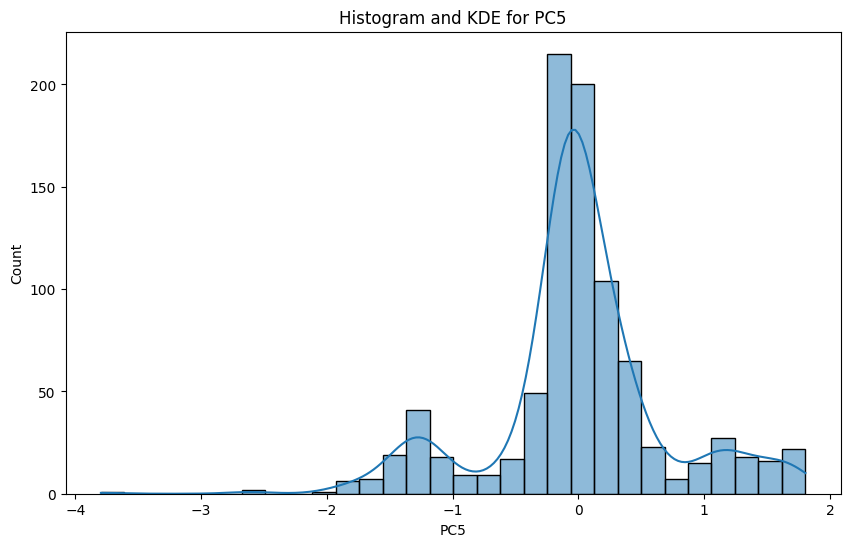

<Figure size 600x600 with 0 Axes>

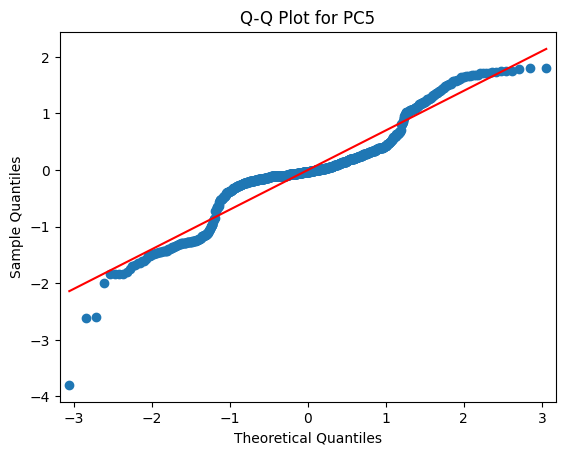

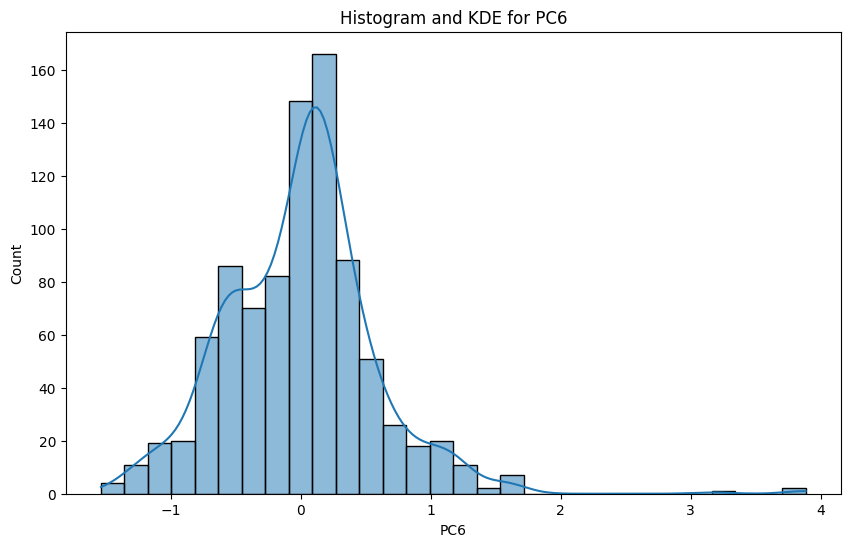

<Figure size 600x600 with 0 Axes>

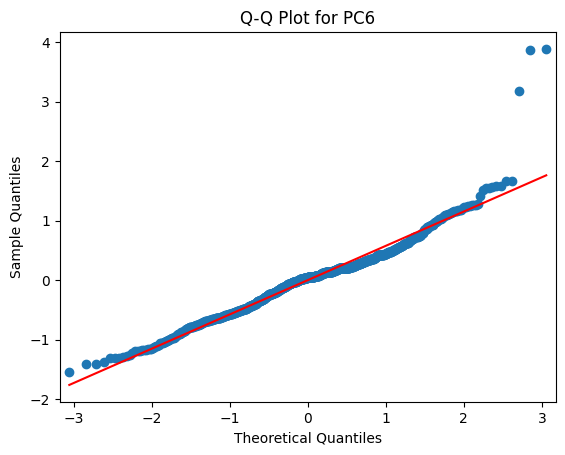

In [44]:
# Analaize the data distribution of the principal components
numeric_features = df_pca.select_dtypes(include=[np.number]).columns

for feature in numeric_features:
    data = df_pca[feature]
    #Histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(data, kde=True, bins=30)
    plt.title(f'Histogram and KDE for {feature}')
    plt.savefig(f'{feature}_histogram.png')

    #QQ plot 
    plt.figure(figsize=(6, 6))
    qqplot(data, line='s')
    plt.title(f'Q-Q Plot for {feature}')
    plt.savefig(f'{feature}_qqplot.png')

    print("")

Correlation Analysis

> Why do we do again a correlation analysis??? Say why

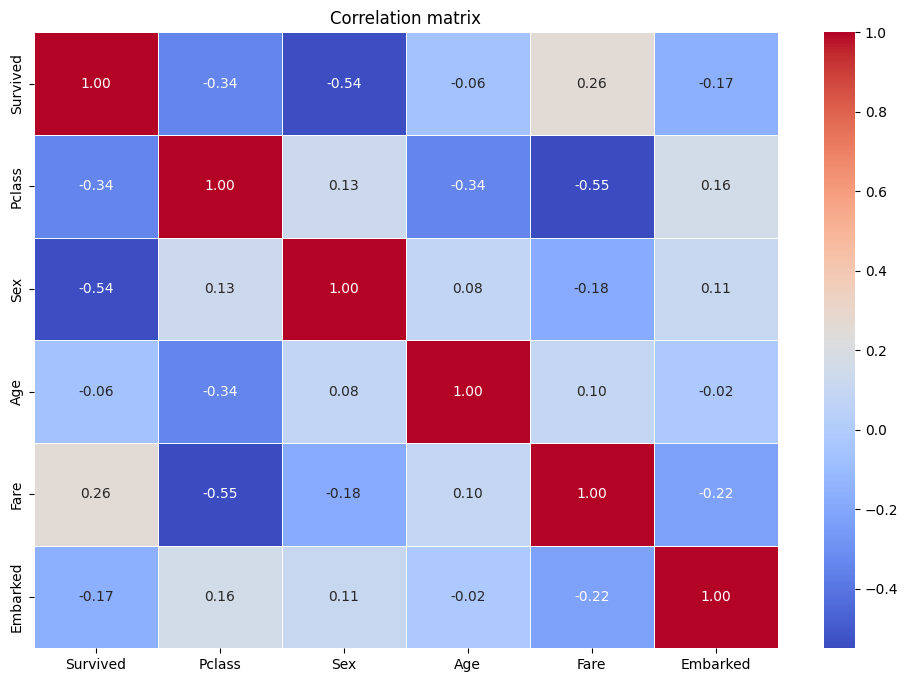

In [46]:
#Correlation matrix
correlation_matrix = data_frame.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation matrix')
plt.savefig('correlation_matrix.png')

# Clasification

### Logistic Regression

Justification: Powerful algorithm for binary classification problems like predicting survival in this case survived or not survided. Plus it is easily interpretable.

> Add more context of why do we choose this algorithm, low specified

In [47]:
#Features and target variable for training
X_train, y_train = data_frame[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']], data_frame['Survived']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

> Add justification of why we add elasticnet, and add a brief description of what is elasticnet (combination of l1 and l2)
> Show with graphs why do we use this approach

In [48]:
#Create and train the logistic regression model
model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(l1_ratio=0.5, max_iter=1000, penalty='elasticnet',
                   solver='saga')

In [49]:
#Import test data set
survived_data_frame = pd.read_csv('gender_submission.csv')
data_frame_test = pd.read_csv('test.csv')

data_frame_test = pd.merge(data_frame_test, survived_data_frame, on='PassengerId')

Drop same columns in the previous dataset we did the feature engineering

In [ ]:
data_frame_test = data_frame_test.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'])

In [51]:
#Transform the data frame
data_frame_test['Sex'] = le.fit_transform(data_frame_test['Sex'])

data_frame_test['Embarked'] = data_frame_test['Embarked'].fillna('S')
data_frame_test['Embarked'] = le.fit_transform(data_frame_test['Embarked'])

data_frame_test['Age'] = data_frame_test['Age'].fillna(data_frame_test['Age'].median())
data_frame_test['Fare'] = data_frame_test['Fare'].fillna(data_frame_test['Fare'].median())

# Create the x and y test
X_test, y_test = data_frame_test[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']], data_frame_test['Survived']

Using the transform for the training data

In [52]:
X_test_scaled = scaler.transform(X_test)

Verify changes

In [54]:
data_frame_test.head()

,Pclass,Sex,Age,Fare,Embarked,Survived
0,3,1,34.5,7.8292,1,0
1,3,0,47.0,7.0000,2,1
2,2,1,62.0,9.6875,1,0
3,3,1,27.0,8.6625,2,0
4,3,0,22.0,12.2875,2,1


**Prediction**

In [55]:
y_pred = model.predict(X_test_scaled)

**Evaluation**

Accuracy:  0.9521531100478469
Classification report: 
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       266
           1       0.91      0.97      0.94       152

    accuracy                           0.95       418
   macro avg       0.94      0.96      0.95       418
weighted avg       0.95      0.95      0.95       418



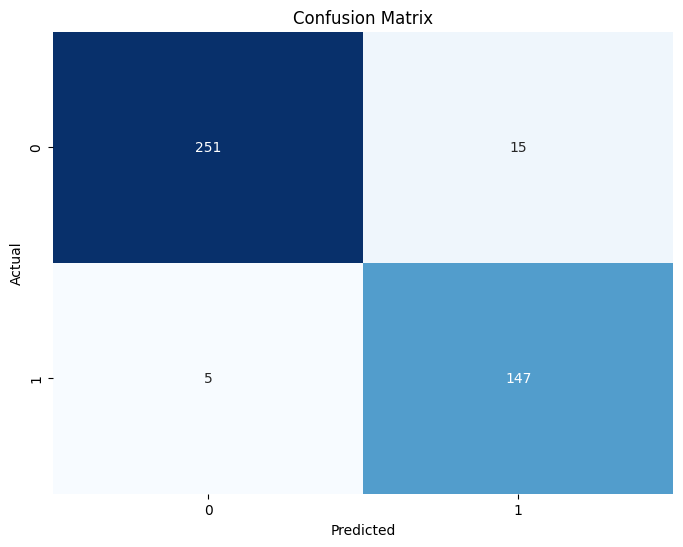

In [57]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

#Creation and plotting of confusing matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')

print("Classification report: ")
print(classification_report(y_test, y_pred))

### Random Forest

Justification: Given the Titanic dataset’s diversity in features (like age, fare, class, etc.), Random Forest can effectively capture the non-linear relationships between features and survival.

> Same, add more justification for this dataset

Separate x and y

In [60]:
X_train = data_frame[['Pclass','Sex','Age','Fare','Embarked']]
y_train = data_frame['Survived']

**Model**

In [61]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

**Predictions**

In [62]:
y_pred = rf_model.predict(X_test)

**Evaluation of the model**

In [69]:
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.8373205741626795
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87       266
           1       0.77      0.80      0.78       152

    accuracy                           0.84       418
   macro avg       0.82      0.83      0.83       418
weighted avg       0.84      0.84      0.84       418



Confusion Matrix

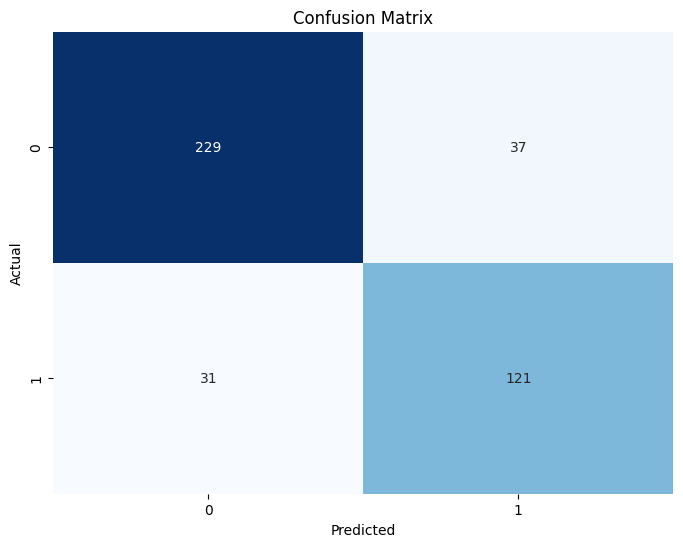

In [71]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')

Plot

> Plot what??? And add axis to the graph you are showing and explain

C:\Users\danyO\AppData\Local\Temp\ipykernel_25784\342588468.py:21: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


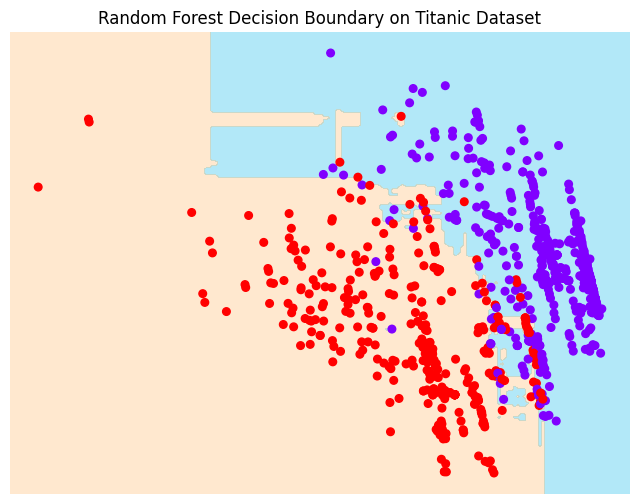

In [72]:
# Función de visualización del clasificador
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()

    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

# Reducir dimensiones con PCA a 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data_frame_scaled)

# Inicializar el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Visualizar el clasificador
plt.figure(figsize=(8, 6))
visualize_classifier(rf_model, X_pca, data_frame['Survived'])
plt.title('Random Forest Decision Boundary on Titanic Dataset')
plt.show()


### Support Vector Machine

Justification: SVM can efficiently classify data points even when the relationship between the features and the target variable is complex.

> Same comment of previous model, add more justification

Declare features

In [81]:
features = ['Pclass', 'Sex', 'Age',  'Embarked']

Apply model and get the best parameters through a grid

In [75]:
model = SVC()
param_grid = {'C':[1,2,5,10,20,50]} 
grs = GridSearchCV(model, param_grid=param_grid, cv = 10, n_jobs=1, return_train_score = False)
grs.fit(np.array(data_frame[features]), np.array(data_frame['Survived']))

GridSearchCV(cv=10, estimator=SVC(), n_jobs=1,
             param_grid={'C': [1, 2, 5, 10, 20, 50]})

Show best parameters

In [77]:
print("Best parameters " + str(grs.best_params_))
gpd = pd.DataFrame(grs.cv_results_)
# ??? Explicat mas esta linea
print("Estimated accuracy of this model for unseen data:{0:1.4f}".format(gpd['mean_test_score'][grs.best_index_]))

Best parameters {'C': 20}
Estimated accuracy of this model for unseen data:0.7935


Transform data

> Esto para que es??

In [82]:
s3_url_test = "https://gatitoenamoraobucket.s3.amazonaws.com/titanic/test.csv"
data_frame_test = pd.read_csv(s3_url_test)
data_frame_test['Sex'] = le.fit_transform(data_frame_test['Sex'])
data_frame_test['Embarked'] = data_frame_test['Embarked'].fillna('S')
data_frame_test['Embarked'] = le.fit_transform(data_frame_test['Embarked']) 

data_frame_test['Age'] = data_frame_test['Age'].fillna(data_frame_test['Age'].median())  
data_frame_test['Fare'] = data_frame_test['Fare'].fillna(data_frame_test['Fare'].median())
pred = grs.predict(np.array(data_frame_test[features]))

sub = pd.DataFrame({'PassengerId':data_frame_test['PassengerId'],'Survived':pred})
sub.to_csv('AgeSexPclassEmbarked.csv', index = False, float_format='%1d')
sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


### K cross validation

> Hacer k cross fold validation PARA CADA UNO DE LOS MODELOS
> Correr varias veces el k cross lo que sea y hacer una grafica de rendimiento, sacar el promedio
> sacar desviacion standard

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


# 2. Configurar K-Fold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)  # K = 10

# 3. Aplicar K-Fold Cross Validation
scores = cross_val_score(rf_model, data_frame_scaled, data_frame['Survived'], cv=kf, scoring='accuracy')

# 4. Mostrar los resultados
print(f"Scores for each fold: {scores}")
print(f"Mean Accuracy: {scores.mean()}")
print(f"Standard Deviation: {scores.std()}")


Scores for each fold: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Accuracy: 1.0
Standard Deviation: 0.0
